In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax  
from sklearn.datasets.samples_generator import make_blobs

Here we implement the simple (2,1) network. $[X_1, X_2]$ by $[V_1]$

In [2]:
# Generate isotropic Gaussian blobs for clustering.
# Here we generate 2 blobs, that will be used for training
# on cluster|ing among 2 classes, where each class has 
# spread (std) 5. That is, generate 2 blobs, for each class 
# (overally 2*2 = 4 blobs).
# The number of data points is 500.
X, _ = make_blobs(n_samples=500, 
                  centers=2,
                  #n_features = 2,
                  cluster_std = 1.0,
                  random_state=1000)
X[:10]

array([[ 5.05352957, -7.06335365],
       [ 8.73109832, -0.01417307],
       [ 8.37702965, -0.80048725],
       [ 9.10785691,  1.03826131],
       [ 7.72287271,  0.2700947 ],
       [ 9.89879645,  0.33035052],
       [ 2.24885075, -6.09977777],
       [ 1.96062893, -8.44186689],
       [ 2.3428721 , -8.39285444],
       [ 8.61440809,  1.39788116]])

In [3]:
X.shape

(500, 2)

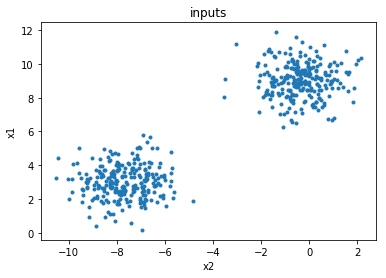

In [40]:
# plot the blobs 
xaxis = [x for x in X[:,0]]
yaxis = [y for y in X[:,1]]
plt.plot(yaxis, xaxis, '.')
plt.title('inputs')  
plt.ylabel('x1')
plt.xlabel('x2')
plt.show()

These are the data points i ll use to train my one-layer net with the oja's update rule. But first i need to scale them to be 0 mean. Let's rescale to mean zero (to be centered around (0,0)) and also let the std be as it is.

Let's visualize.

In [41]:
from sklearn.preprocessing import StandardScaler

# StandardScaler has by default scale data to have 0 mean and variance 1.
# Here we want to leave variance intact and only make the data 0 mean.
scaler = StandardScaler(with_std=False)
X_scaled = scaler.fit_transform(X)

def analyze_data(X):    
    
    # configure some parameters of the "lookings" of the plot.
    plt.figure(num=None, 
               figsize=(8, 6), 
               dpi=80, 
               facecolor='w', 
               edgecolor='k')
   
    # plot data
    xaxis = [x for x in X[:,0]]
    yaxis = [y for y in X[:,1]]
    plt.plot(yaxis, xaxis, '.')
    plt.ylabel('inputs')    
    
    # correlation matrix
    C = np.cov(X_scaled.T) # equivalent to X_scaled.T*x_scaled (2,500)*(500,2) = (2,2)
    
    # SVD
    eigenvalues, eigenvectors = np.linalg.eig(C)
    print ('Covariance matrix is : \n' , C)
    print ('eigenvalues are: \n', eigenvalues)
    print ('eigenvectors are: \n', eigenvectors)  
    
    # plot eigenvectors
    for i in  range(2):    
        xaxis_e = [0] # remember the data X is scaled to mean 0.
        xaxis_e.append(eigenvectors[0,i])
        yaxis_e = [0]
        yaxis_e.append(eigenvectors[1,i])
        plt.plot(yaxis_e, xaxis_e, '-')
        plt.title('inputs')
        plt.ylabel('x1')
        plt.xlabel('x2')
        
    # alternative way to plot if you do above np.linalg.eig(np.matrix(C))
    #x_v1, y_v1 = eigenvectors[:,0].getA1()
    #x_v2, y_v2 = eigenvectors[:,1].getA1()
    #m1 = y_v1/x_v1  # Gradient of 1st eigenvector
    #m2 = y_v2/x_v2 # Gradient of 2nd eigenvector
    #plt.plot([x_v1*-5, x_v1*5], [y_v1*-5, y_v1*5], color='royalblue')
    #plt.plot([x_v2*-5, x_v2*5], [y_v2*-5, y_v2*5], color='crimson')

    # show the plots 
    plt.show()
    
    return C, eigenvalues, eigenvectors

Covariance matrix is : 
 [[ 10.01131474  11.06169834]
 [ 11.06169834  14.53063507]]
eigenvalues are: 
 [  0.9808361   23.56111371]
eigenvectors are: 
 [[-0.77464333 -0.63239838]
 [ 0.63239838 -0.77464333]]


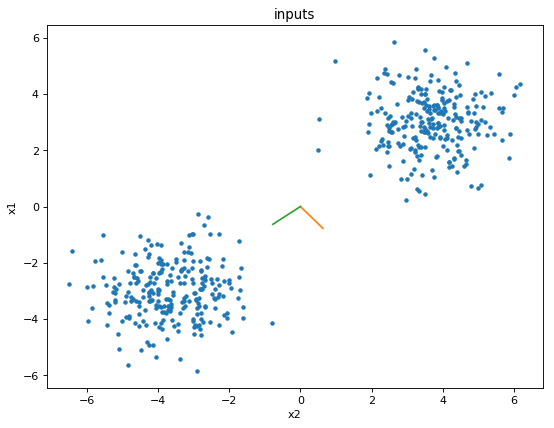

In [42]:
C, eigenvalues, eigenvectors = analyze_data(X_scaled)

These are the final (scaled) data points.

In [31]:
print (C)
print (eigenvalues)
print (eigenvectors)

[[ 10.01131474  11.06169834]
 [ 11.06169834  14.53063507]]
[  0.9808361   23.56111371]
[[-0.77464333 -0.63239838]
 [ 0.63239838 -0.77464333]]


Notice how the eigenvectors are orthogonal (eigenvector 1 is column 1 and eigenvector 2 is column 2).

In [32]:
index = np.argmax(eigenvalues, axis=0)
max_eigenvector = eigenvectors[:,index]
max_eigenvector

array([-0.63239838, -0.77464333])

The max eigenvector (principal component), is the second column of the eigenvectors array. I expect the weights of my algorithm to converge along this eigenvector.

Now onto the oja's implementation..

We have defined the single output unit, representing the variance : 

$$\begin{equation*}
V^2 = (W^T*X)*(W^T*X)^T = W^T(X^T*X)*W = W^T*C*W
\end{equation*}
$$

And the oja's update rule is :
$$
\begin{equation*}
dW = C*W - (W^T*C*W)*W
\end{equation*}
$$

which element-wise translates into:

$$
\begin{equation*}
dw_{i} = lr * V(x_{i} - V*w_{i}) \\\
= lr *( V*x_{i} - V^2*w_{i}) \\\ 
= lr * (\sum_{j=1}^n w_{j}*x_{j}*x_{i} - (\sum_{j,k}^n w_{j}*x_{j}*w_{k}*x_{k})*w_{i}) \\\
= lr * (\sum_{j=1}^n w_{j}*c_{ij} - (\sum_{j,k}^n w_{j}*w_{k}*c_{jk})*w_{i}) \\\
\end{equation*}
$$

comment: don't forget here, V is just a number - or better a (1,1) matrix. Regarding the rest of the matrices W is (n,1), C is (n,n), X is (m,n), where m the number of the examples. Overally Ojas's net, is a 1-layer, n-input to 1-output network. 

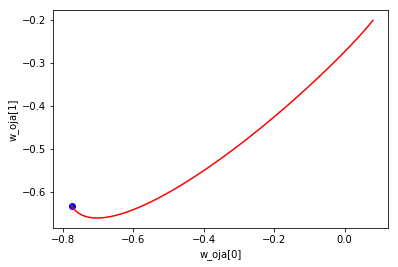

In [33]:
# apply the oja's rule

# initialize the weights, w_oja
np.random.seed(1000) # make results repeatable
w_oja = np.random.normal(scale=0.25, size=(2,1))

# Set the threshold of tolerance, close to 0.
# This will be the flag point to end the loop,
# when the difference between new and the previous
# weights is almost zero. Then, we need also to 
# initialize the weights we will keep as flag, w_oja_prev.
threshold = 1e-8
w_oja_prev = np.ones((2,1))

# update rule
learning_rate = 0.001
listx = []
listy = [] 
while np.linalg.norm(w_oja - w_oja_prev) > threshold:
    w_oja_prev = w_oja.copy()
    rule = np.dot(C,w_oja) - np.dot(w_oja.T, np.dot(C,w_oja))*w_oja # (2,2)dot(2,1) - (1,2)dot(2,2)dot(2,1)*(2,1)
    w_oja += learning_rate * rule
    # keep a list of the x and y axis to plot next, the convergence of the 
    # oja weights w_oja to the max_eigenvector    
    listx.append(w_oja_prev[0])
    listy.append(w_oja_prev[1])
    
# append the last w_oja point to my lists
listx.append(w_oja[0]) 
listy.append(w_oja[1])

# plot 
plt.plot(listy, listx, 'r')
plt.scatter(max_eigenvector[1], max_eigenvector[0], color='b')
plt.xlabel('w_oja[0]')
plt.ylabel('w_oja[1]')
plt.show()

Notice how it converges to the max eigenvector! Let's check that it indeed converges to the numerical value

In [34]:
w_oja

array([[-0.63239871],
       [-0.77464306]])

In [35]:
max_eigenvector

array([-0.63239838, -0.77464333])

In [36]:
# this raises error because w_oja and max_eigenvector are not exactly the same.
if not w_oja == max_eigenvector:
    raise AssertionError()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

They are not exactly the same however! Remember we have set a threshold value of acceptance!